# SCS 3546 Deep Learning Module 3

# Convolutional Neural Networks

***


 # Learning Objectives

By the end of this module, you will:

- Understand the theory and motivation behind convolutional neural networks.

- Be able to build and train a basic CNN using Keras. 

- Be able to identify several diverse applications of CNN. 

- Gain exposure to some of the most important CNN architectures of recent years: LeNet-5, AlexNet, GoogLeNet, ResNet

- Gain insight into how transfer learning allows us to repurpose an existing model to new target tasks.

# Setup

First, let's make sure this notebook has all the required libraries, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [4]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import os

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

#Import tensorflow
import tensorflow as tf
from tensorflow import keras  
from tensorflow.keras import layers  


# Introduction to Convolutional Networks

- Convolutional neural networks (CNNs) emerged from the study of the brain’s visual cortex, and they have been used in image recognition since the 1980s. 

- In the last few years, thanks to the increase in computational power, the amount of available training data, and better training techniques for deep nets, CNNs have managed to achieve performances equal to or exceeding that of humans for visual identification tasks.

- They power applications such as image search services, self-driving cars, automatic video classification systems, and more. They are also successful at other tasks, such as voice recognition or natural language processing.

## Why Not a Fully Connected Network?

- Fully connected (or "Dense") layers work well for small images (e.g., MNIST). However, this breaks down for larger images due to the large number of trainable parameters required. 
    - For example, a 100 × 100 image has 10,000 pixels,
    - If the first layer has just 1,000 neurons this means a total of 10 million connections,
    - And that’s just the first layer!
- The large number of trainable parameters can also lead to overfitting. 
- CNNs solve this problem using partially connected layers and 'shared' weights, which yields greater representational power with fewer tunable parameters.

## Inspiration from Nature: Architecture of the Visual Cortex

- David H. Hubel and Torsten Wiesel performed a series of experiments on cats in 1958 and 1959 giving crucial insights on the structure of the visual cortex. (Nobel Prize in Medicine in 1981). 
- They showed that many neurons in the visual cortex have a small local receptive field:
    - The receptive fields of different neurons may overlap, and together they tile the whole visual field. 
    - They showed that some neurons react only to images of horizontal lines, while others react only to lines with different orientations. 
    - They also noticed that some neurons have larger receptive fields, and they react to more complex patterns that are combinations of the lower-level patterns. 
- Their observations led to the idea that the higher-level neurons are based on the outputs of neighboring lower-level neurons.

- This led to the idea of 'convolutional' layers, described next, which are the building block of CNNs.

<img src="https://drive.google.com/uc?id=18xe2XergIDJLRkQXpoZhVE42XJJ6WAeu">


## Convolutional Layer

- The idea behind a 'convolutional' layer is that its neurons are not connected to every single element in the layer before it. Instead, the neurons have a limited receptive field.

- For example, in the first convolutional layer in a CNN, each neuron might be connected only to the closest 3x3 grid of image pixels in the layer beneath it. 

- In turn, each neuron in the second convolutional layer is connected only to neurons located within a small rectangle in the first layer. 

<img src="https://drive.google.com/uc?id=1jH-_bIk1h4t20f7EY8Xm5PxYNqH2PkZB">

- This architecture allows the network to concentrate on low-level features in the first convolution layer, then assemble them into higher-level features in the next hidden layer, and so on. 

- Another important difference is that the neurons in each layer have shared weights. That is to say, if each neuron connects to a 3x3 pixel receptive field, the connection weights w(1, 1), w(1, 2), w(1, 3), w(2, 1) ... w(3, 3) will be the **same** for all neurons in that layer. 

- In other words, the weights represent a 'mask' or 'filter' that multiplies the values of the pixels in the receptive field. This acts as a feature detector for the pattern represented by that particular mask, producing a strong signal to the neuron when there is a close match to the mask, and a weak signal if there is a poor match. 

- These weights, and therefore the 'filters' that get applied, are learned during training. 



### Connections between layers and zero padding


- Let $f_h$ and $f_w$ be the height and width of the receptive field, respectively. 

- A neuron located in row $i$, column $j$ of a given layer is connected to the outputs of the neurons in the previous layer located in rows $i$ 
to $i + f_h – 1$, columns $j$ to $j + f_w – 1$. 


- In order for a layer to have the same height and width as the previous layer, it is common to add zeros around the inputs.

<img src="https://drive.google.com/uc?id=17mCgpukYy2wzoHjvNbhRawmU29HzKX3b">






## Stride

- It is also possible to connect a large input layer to a much smaller output layer by spacing out the receptive fields. The distance between two consecutive receptive fields is called the stride. 



##### A 5 × 7 input layer (plus zero padding) is connected to a 3 × 4 layer, using 3 × 3 receptive fields and a stride of two. 

<img src="https://drive.google.com/uc?id=14bu_nmar0nhBfdhpG6syzJJ3xEjJKymK">

- By using a stride greater than one, the dimentionality of the layer can be reduced.

## Filters

- A neuron’s weights can be represented as a small image the size of the receptive field. 
    - In the example below, we have two possible sets of weights, called filters (or convolution kernels). 
        - The first one is represented as a black square with a vertical white line in the middle. Mathematically, this would be an array with `1`'s where the vertical white line is, and zeros elsewhere. Neurons using these weights will ignore everything in their receptive field except for the central **vertical** line 
        - The second filter is a black square with a horizontal white line in the middle. Neurons using these weights will ignore everything in their receptive field except for the central **horizontal** line.

<img src="https://drive.google.com/uc?id=15In-zV9iGufEaNGI-pbs1r1Sz8OMnnin">

- A layer full of neurons using the same filter gives you a feature map, which highlights the areas in an image that are most similar to the filter. 
    - If all neurons in a layer use the same vertical line filter, the layer output  will enhance the white vertical lines, the rest gets blurred. 
    - Similarly, for the horizontal line filter. 
- During training, a CNN finds the most useful filters for its task, and it learns to combine them into more complex patterns 

- Applying a filter across an input layer results in an activation pattern of the filter layer's neurons. We typically call this output activation pattern a _filter map_.

### Mathematical Representation of a Convolution

In image processing, a **kernel**, **filter**, or **mask** is a small matrix used for blurring, sharpening, embossing, edge detection, and more. Mathematically, this can be represented as a 'convolution' between an image array and a matrix representing the filter being applied. 

$$
\left[\begin{array}{cccc}{x_{11}} & {x_{12}} & {\cdots} & {x_{1 n}} \\ {x_{21}} & {x_{22}} & {\cdots} & {x_{2 n}} \\ {\vdots} & {\vdots} & {\ddots} & {\vdots} \\ {x_{m 1}} & {x_{m 2}} & {\cdots} & {x_{m n}}\end{array}\right] *\left[\begin{array}{cccc}{y_{11}} & {y_{12}} & {\cdots} & {y_{1 n}} \\ {y_{21}} & {y_{22}} & {\cdots} & {y_{2 n}} \\ {\vdots} & {\vdots} & {\ddots} & {\vdots} \\ {y_{m 1}} & {y_{m 2}} & {\cdots} & {y_{m n}}\end{array}\right]=\sum_{i=0}^{m-1} \sum_{j=0}^{n-1} x_{(m-i)(n-j)} y_{(1+i)(1+j)}
$$

![](https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/keras-conv2d/keras_conv2d_padding.gif)

[ref: https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/]

## Stacking Multiple Feature Maps

- In practice, convolutional layers are composed of **multiple** feature maps of equal sizes, so a convolutional layer of neurons is more accurately represented in 3D, where the 'depth' dimension comes from the number of filters. This means there are several different filters that can be learned and applied to any given layer. 
    - Within one feature map, all neurons share the same parameters.
    - A convolutional layer simultaneously applies multiple filters to its inputs, making it capable of detecting multiple features anywhere in its inputs.
    - A feature map that shares the same parameters dramatically reduces the number of parameters in the model. More importantly, it means that once the CNN has learned to recognize a pattern in one location, it can recognize it in any other location. 
    - Thusfar we have considerd mostly greyscale images. But for colour images, the input can also be composed of multiple sublayers: one per color channel (R, G, B).

    - We often refer to the depthwise dimension of our layers as "channels".
    

<img src="https://drive.google.com/uc?id=1z6JBdtnJKqT9LdJcpZ_5O2V-ZQ3ck-D9">



- A neuron located in row $i$, column $j$ of the feature map $k$ in a given convolutional layer $l$ is connected to the outputs of the neurons in the previous layer $l – 1$, located in rows $i × s_h$ to $i × s_h + f_h – 1$ and columns $j × s_w$ to $j × s_w + f_w – 1$, across all feature maps (in layer $l – 1$).

$$
z_{i, j, k}=b_{k}+\sum_{u=0}^{f_{h}-1} \sum_{v=0}^{f_{v}-1} \sum_{k=0}^{f_{f}-1} x_{i^{\prime}, j^{\prime}, k^{\prime}} w_{u, v, k^{\prime}, k} \quad \text { with }\left\{\begin{array}{l}{i^{\prime}=i \times s_{h}+u} \\ {j^{\prime}=j \times s_{w}+v}\end{array}\right.
$$

- $z_{i,j,k}$ is the output of the neuron located in row $i$, column $j$ in feature map $k$ of the convolutional layer (layer $l$).

- $s_h$ and $s_w$ are the vertical and horizontal strides, $f_h$ and $f_w$ are the height and width of the receptive field, and $f_n′$ is the number of feature maps in the previous layer (layer $l – 1$).

- $x_{i′, j′, k′}$ is the output of the neuron located in layer $l – 1$, row $i′$, column $j′$, feature map $k′$

- $b_k$ is the bias term for feature map $k$ (in layer $l$). 

- $w_{u, v, k′ ,k}$ is the connection weight between any neuron in feature map $k$ of the layer $l$ and its input located at row $u$, column $v$, and feature map $k′$.

## Putting it all together: CNNs

As seen in the diagram below, a convolutional neural network (CNN) will be comprised of multiple convolution layers stacked on top of each other, sometimes mixed in with additional 'subsampling' or 'pooling' layers that further reduce the dimensionality of the output by only keeping the max or overage value of pixels found in its receptive fields. 

The convolution and pooling layers are followed by a 'classifier' layer at the output that specializes the network for a particular supervised learning task. The classifier layer is typically a Dense (fully-connected) layer that maps the features learned in the layer below to an output class (if classification) or continuous value (if regression). Prior to the dense layer, the feature maps in the layer before are flattened into 1D vectors and concatenated, so that the input to the dense layer is a 1D vector of values representing the activations of those features. 

So in other words, our convolutional layers are simply (a) learning good feature representations for the problem at hand and (b) converting the input images into feature vectors of these learned features. You can think of this as forming an 'encoder' stage producing a vector that is a more useful representation of our image for the ML task. This then becomes the input to the type of fully-connected neural network classifiers we learned about in Module 1 and 2. 







<img src="https://drive.google.com/uc?id=1d-MGBSEthITcBGEuuIw2cGJEY_SuUJ_X">
    

# Implementing a CNN in Tensorflow

- In TensorFlow, each input image is typically represented as a 3D tensor of shape [height, width, channels]. 
- A mini-batch is represented as a 4D tensor of shape [mini-batch size, height, width, channels]. 
- The weights of a convolutional layer are represented as a 4D tensor of shape [fh, fw, fn′, fn], where $f_h$ and $f_w$ are the height and width coordinates within the receptive field, $f_{n}'$ specifies a filter map or channel in the layer before, and $f_{n}$ specifies a feature map in the current layer.
- The bias terms of a convolutional layer are simply represented as a 1D tensor of shape [fn].



## Applying a 2D Convolutional Layer

Before building a model, let's first look at applying a simple 2D convolution with Tensorflow. 

The following loads two sample images. It then creates two 7x7 filters and aplies them to both images using a convolutional layer built using TensorFlow’s `tf.nn.conv2d()` function 

In [2]:
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")


In [ ]:
# A note on dimensions:

# The input image array is of dimension: 
# (batch_size, num vertical pixels, num horizontal pixels, num channels)

# In this case, we have 2 input images that are 427x640 pixels and have
# three colour channels (Red, Green, Blue). 

print(f"Dimension of input tensor: {images.shape}")

Dimension of input tensor: (2, 427, 640, 3)


In [ ]:
# The filters array is of dimension:
# (num vertical receptive field pixels, num horizontal receptive field pixels, 
#  num input channels or filters, num filters in layer)

# In this case, we have a 7x7 receptive field (i.e. filter size), there are
# three input channels (Red, Green, Blue), and two filters being applied
print(f"Dimension of filters tensor: {filters.shape}")

Dimension of filters tensor: (7, 7, 3, 2)


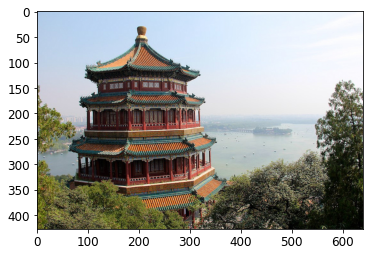

In [ ]:
# let's plot the first image (original) before applying our filters
plt.imshow(images[0]) 
plt.show()

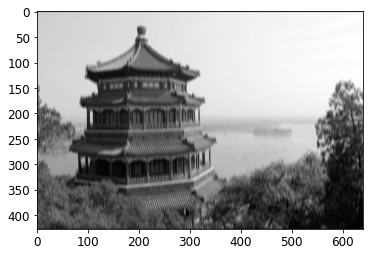

In [ ]:
# plot 1st image's 1st feature map (vertical filter), to see the output of the filter;
# we see vertical features sharpened, horizontal features blurrered
plt.imshow(outputs[0, :, :, 0], cmap="gray") 
plt.show()

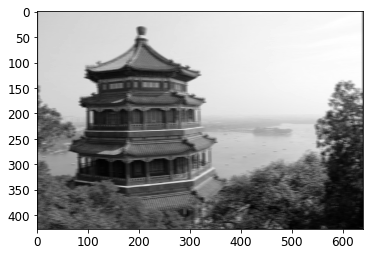

In [ ]:
# plot 1st image's 2nd feature map (hotizontal filter);
# we see horizontal features sharpened, vertical features blurrered
plt.imshow(outputs[0, :, :, 1], cmap="gray") 
plt.show()

## Layer Padding

Note that in the above example, we used `padding="SAME"` as a parameter to `tf.nn.conv2d`. 

- Padding must be either "VALID" or "SAME":

    - If set to "VALID", the convolutional layer does not use zero padding, and may ignore some rows and columns at the bottom and right of the input image.
    - If set to "SAME", the convolutional layer uses zero padding if necessary to ensure that all inputs are sampled by the filters.
    
    

<img src="https://drive.google.com/uc?id=1Knike3qXCgi-Rzwrb7H8G1zNy7EAaf6Q">
    
    

## Pooling layer

Earlier we mentioned that 'pooling' layers are also typically intermixed with convolutional layers in a CNN. Let's talk more about them:

- Their goal is to subsample the input image in order to reduce the computational load, memory usage, and number of parameters.
- Each neuron in a pooling layer is connected to the outputs of a limited number of neurons in the previous layer, located within a small rectangular receptive field.
- Parameters: size, stride, and padding type. 
- Note that, a pooling neuron has no weights; it aggregates the inputs using a function such as the max or mean. 

<img src="https://drive.google.com/uc?id=1lOlduu3zlh1rqmgPngKfFG7ZzNXLURfL">

In this example, we use a 2 × 2 pooling kernel, a stride of 2, no padding, and max aggregation.


- A small 2 × 2 kernel and a stride of 2 will make the output two times smaller in both directions (so its area will be four times smaller).

- A pooling layer works on every input channel independently, so the output depth is the same as the input depth. 

- Note that, instead of pooling over the horizontal and vertical values in a given channel, you can also pool over the depth dimension to aggregate over multiple channels. See the Geron textbook for more discussion on this. 


The following code creates a max pooling layer using a 2 × 2 kernel, stride 2, and no padding.

In [ ]:
max_pool = keras.layers.MaxPool2D(pool_size=2, strides=2)

# Image Classification with Keras

Enough talk - let's build a CNN and see it in action! We'll test our network on the familiar MNIST handwritten digit dataset. 





In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow import keras


# === Preparing the Input Data ===

num_classes = 10

# input image dimensions
# these are greyscale images, so we'll have only 1 input channel 
img_rows, img_cols = 28, 28
num_channels = 1

# the data, split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, img_rows, img_cols, num_channels)
X_test = X_test.reshape(10000, img_rows, img_cols, num_channels)

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to one-hot encoded vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

60000 train samples
10000 test samples
Shape of X_train: (60000, 28, 28, 1)
Shape of y_train: (60000, 10)


Convolutional networks have many hyperparameters you will have to tune. For example: 
- the number of filters in a given layer
- the filter (kernel) size
- how much pooling to apply
- number of dense layers and neurons in the output

Let's start simple:

In [ ]:
# we'll use the Keras Sequential API to build the network

model = Sequential()

# the first layer will apply 4 filters
model.add(
    Conv2D(
        filters=4, 
        kernel_size=(3, 3),
        activation='relu', 
        input_shape=(img_rows, img_cols, num_channels)
    )
)

# the second layer will apply a single filter
model.add(Conv2D(1, (3, 3), activation='relu'))

# apply max pooling to downsize the output by a factor of 2
# on each dimension
model.add(MaxPooling2D(pool_size=(2, 2)))

# apply dropout for regularization
model.add(Dropout(0.25))

# flatten the output features to perform standard softmax classification
model.add(Flatten())

# the dense layer learns the 'classification' part of our task
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 4)         40        
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 1)         37        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 1)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 12, 12, 1)         0         
                                                                 
 flatten (Flatten)           (None, 144)               0         
                                                                 
 dense (Dense)               (None, 128)               18560     
                                                        

In [ ]:
# let's compile the model and perform training

batch_size = 128
epochs = 10

model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

# note: although we use the test data for validation here, 
# you really should be cutting a separate validation dataset
# from the full training set, and use the test set as a holdout
# set for final evaluation only
history = model.fit(
    X_train, 
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test)
)
score = model.evaluate(X_test, y_test, verbose=0)

print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Epoch 1/10
469/469 [==============================] - 5s 8ms/step - loss: 7.9501 - accuracy: 0.6885 - val_loss: 0.7224 - val_accuracy: 0.8409
Epoch 2/10
469/469 [==============================] - 3s 7ms/step - loss: 0.8820 - accuracy: 0.7716 - val_loss: 0.4690 - val_accuracy: 0.8591
Epoch 3/10
469/469 [==============================] - 3s 7ms/step - loss: 0.5924 - accuracy: 0.8245 - val_loss: 0.3584 - val_accuracy: 0.8961
Epoch 4/10
469/469 [==============================] - 3s 6ms/step - loss: 0.4780 - accuracy: 0.8542 - val_loss: 0.3101 - val_accuracy: 0.9104
Epoch 5/10
469/469 [==============================] - 3s 6ms/step - loss: 0.4009 - accuracy: 0.8755 - val_loss: 0.2676 - val_accuracy: 0.9196
Epoch 6/10
469/469 [==============================] - 3s 6ms/step - loss: 0.3496 - accuracy: 0.8890 - val_loss: 0.2350 - val_accuracy: 0.9310
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3126 - accuracy: 0.9017 - val_loss: 0.2098 - val_accuracy: 0.9350
Epoch 

If you compare this to the fully-connected (dense) model we trained in Module 1, we are able to achieve an accuracy boost of between 2-4% while using only 1/10th of the parameters.

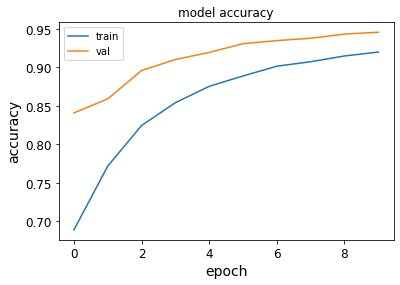

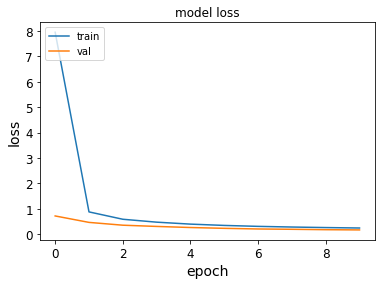

In [ ]:
# let's plot the learning curves

# note: it's unusual for val accuracy to be higher than training
# accuracy; that must have happend due to chance, or perhaps
# we should have better shuffled our input data

def plot_learning_curves(history):

  # plot curves for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  # plot curves for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

plot_learning_curves(history)

### Exercise

Now it's your turn to build a CNN. This time we'll set out to classify the Fashion MNIST dataset. 


In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


Instead of rescaling and reshaping our input data as part of one-off data preprocessing, why don't we make those transformations part of the network architecture itself?

You can do these two tasks easily by using following layers in your code

```
    keras.layers.experimental.preprocessing.Rescaling(1./255),
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))
```

In [ ]:
### your code here 




In [ ]:
### your code here 




In [ ]:
### your code here 




In [ ]:
### your code here 




### Solution

In [ ]:
model = keras.models.Sequential([
    keras.layers.experimental.preprocessing.Rescaling(1./255), # pixel normalization
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)), # flatten the inputs
    keras.layers.Conv2D(64, 7, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same",),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same",),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same",),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same",),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(max(max(test_labels), max(train_labels))+1, activation='softmax')
])

In [ ]:
# with those two preprocessing layers as part of our network, 
# we can feed the network the raw images in their original unscaled
# 28 x 28 pixel format
train_images.shape

(60000, 28, 28)

In [ ]:
test_labels.shape

(10000,)

In [ ]:
# compile and train
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(train_images, train_labels, epochs=10, batch_size=128 , validation_data=(test_images, test_labels))


Epoch 1/10
469/469 [==============================] - 13s 23ms/step - loss: 0.6860 - accuracy: 0.7526 - val_loss: 0.3656 - val_accuracy: 0.8644
Epoch 2/10
469/469 [==============================] - 10s 22ms/step - loss: 0.3616 - accuracy: 0.8713 - val_loss: 0.3050 - val_accuracy: 0.8912
Epoch 3/10
469/469 [==============================] - 10s 22ms/step - loss: 0.2991 - accuracy: 0.8931 - val_loss: 0.2781 - val_accuracy: 0.8967
Epoch 4/10
469/469 [==============================] - 10s 22ms/step - loss: 0.2627 - accuracy: 0.9058 - val_loss: 0.2677 - val_accuracy: 0.9020
Epoch 5/10
469/469 [==============================] - 11s 23ms/step - loss: 0.2365 - accuracy: 0.9147 - val_loss: 0.2423 - val_accuracy: 0.9121
Epoch 6/10
469/469 [==============================] - 10s 22ms/step - loss: 0.2136 - accuracy: 0.9228 - val_loss: 0.2592 - val_accuracy: 0.9103
Epoch 7/10
469/469 [==============================] - 10s 22ms/step - loss: 0.1949 - accuracy: 0.9284 - val_loss: 0.2487 - val_accuracy:

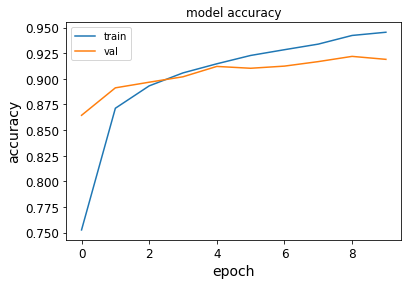

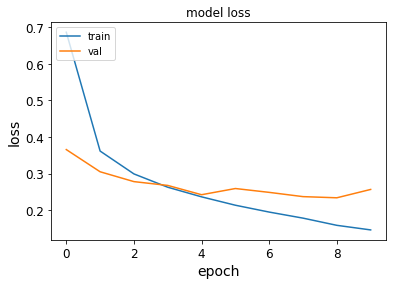

In [ ]:
# let's view the learning curves
plot_learning_curves(history)

# A Note on Memory requirements

Convolutional layers require a huge amount of RAM, especially during training, because the reverse pass of backpropagation requires all the intermediate values computed during the forward pass.

Example: A convolutional layer with 5 × 5 filters, outputting 200 feature maps of size 150 × 100, with stride 1 and SAME padding. 
- If the input is a 150 × 100 RGB image (three channels), then the number of parameters is (5 × 5 × 3 + 1) × 200 = 15,200 
- However, each of the 200 feature maps contains 150 × 100 neurons, and each of these neurons needs to compute a weighted sum of its 5 × 5 × 3 = 75 inputs: that’s a total of 225 million float multiplications. 
- If the feature maps are represented using 32-bit floats, then the convolutional layer’s output will occupy 200 × 150 × 100 × 32 = 96 million bits (about 11.4 MB) of RAM.
- If a training batch contains 100 instances, then this layer will use up over 1 GB of RAM!

If training crashes because of an out-of-memory error, try:
- reducing the mini-batch size,
- reducing dimensionality using a stride, 
- remove a few layers,
- use 16-bit floats instead of 32-bit floats,
- distribute the CNN across multiple devices.

# Data Preprocessing Tips


As you already know by now, data should be formatted into appropriately pre-processed floating point tensors before being fed into our network. 

In the examples above, we loaded data from either online sources or using built-in datasets where the data was already converted to numpy arrays. 

What if our data sits on a drive or a directory on cloud as JPEG files? In this case the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RGB grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).


Below: example of a greyscale image represented as an array of normalized pixel values.

![alt text](http://ai.stanford.edu/~syyeung/cvweb/Pictures1/imagematrix.png)

Ref: http://ai.stanford.edu/~syyeung/cvweb/tutorial1.html

## Reading image data into your workspace

Let's start by downloading our example data, a .zip of 2,000 JPG pictures of cats and dogs, and extracting it locally in `/tmp`.

**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [ ]:
# the '!' jupyter magic allows you to execute shell commands
# from a notebook cell; here we are downloading a file from a url
# using the shell 'wget' CLI command
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2022-10-02 17:30:13--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   273MB/s    in 0.2s    

2022-10-02 17:30:14 (273 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
# extracting the contents of the zip file

import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

The contents of the .zip are extracted to the base directory `/tmp/cats_and_dogs_filtered`, which contains `train` and `validation` subdirectories for the training and validation datasets (see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/validation/check-your-intuition) for a refresher on training, validation, and test sets), which in turn each contain `cats` and `dogs` subdirectories. Let's define each of these directories:

In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Now, let's see what the filenames look like in the `cats` and `dogs` `train` directories (file naming conventions are the same in the `validation` directory):

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.380.jpg', 'cat.524.jpg', 'cat.722.jpg', 'cat.730.jpg', 'cat.441.jpg', 'cat.901.jpg', 'cat.26.jpg', 'cat.916.jpg', 'cat.830.jpg', 'cat.563.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Let's find out the total number of cat and dog images in the `train` and `validation` directories:

In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


For both cats and dogs, we have 1,000 training images and 500 test images.

Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplot parameters:

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 cat and 8 dog pictures. You can rerun the cell to see a fresh batch each time:

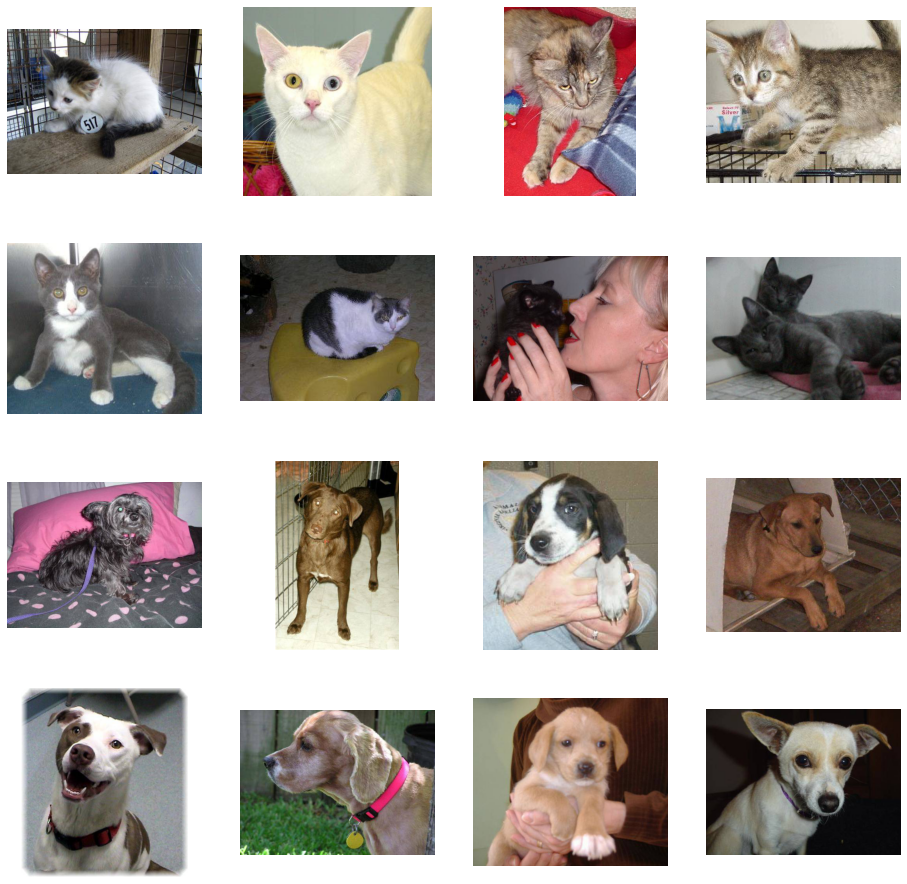

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


In [ ]:
# the 'img' objects that mpimg.imread(img_path) provides is 
# already in the correct format for you to work with; mpimg
# has converted from jpeg to an image array for you
print(f'Object type: {type(img)}')
print(f"Array shoape: {img.shape}")


Object type: <class 'numpy.ndarray'>
Array shoape: (375, 499, 3)


## Converting On-Disk Images to Tensorflow Datasets

Tensorflow also has a helpful utility for converting images on disk to Tensorflow Dataset objects, which can be helpful if your dataset size is too large to hold entirely in memory at once. See here for more info on the Dataset API: https://www.tensorflow.org/guide/data

For demonstrating using `image_dataset_from_directory` we are using a flower dataset containing roughly 3,700 photos of flowers. The dataset contains 5 sub-directories, one per class. The following code snipped downloads the data. 

In [3]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 1s 0us/step


We can view each of the images using the `PIL` library as follows:

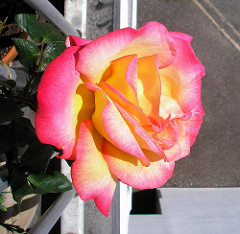

In [5]:
import PIL

roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

Let's load these images off disk using the helpful `image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code.

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


## Data Augmentation


Sometimes, the features that a CNN learns for identifying an object might be 'overfit' to unexpected aspects of the image. For example, the model might be highly sensitive to lighting conditions or the angle of the camera with respect to the target object. In such cases, even slightly different contrast levels or orientations of the object could cause a misclassification. 

One way to mitigate this issue is to provide a more varied input data distribution for that object. For example, we'd want our network to learn what a cat is irrespective of the cat's size, colour, orientation to the camera, the ambient lighting conditions, and so forth. 

Data augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same picture twice. This helps the model get exposed to more aspects of the data and generalize better.



#### ImageDataGenerator

Keras provides an `ImageDataGenerator` class that can be configured to perform data augmentation by applying randomized transformations on our dataset as it is fed to the model during training. 

The following example demonstrates this:

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.5,
      zoom_range=0.6,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* **rotation_range** is a value in degrees (0-180), a range within which to randomly rotate pictures.
* **width_shift** and **height_shift** are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
* **shear_range** is for randomly applying shearing transformations.
* **zoom_range** is for randomly zooming inside pictures.
* **horizontal_flip** is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal asymmetry (e.g. real-world pictures).
* **fill_mode** is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

In [ ]:
train_generator = datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(224, 224),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 2000 images belonging to 2 classes.


In [ ]:
# printing the shapes of the arrays we just loaded in
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break
    

data batch shape: (20, 224, 224, 3)
labels batch shape: (20,)


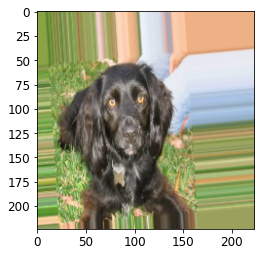

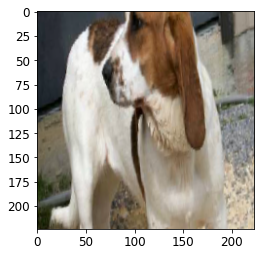

In [ ]:
# here we display images that have had data augmentation
# transformations applied to them (such as shearing, zooming, 
# rotations, etc.) via the ImageDataGenerator we intantiated
# and configured
from tensorflow.keras.preprocessing import image
i = 0
for batch in train_generator:
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0][0]))
    i += 1
    if i % 2 == 0:
        break

#### Data Augmentation with Custom Preprocessing Layers

You can also use preprocessing layers for data augmentation as well.

Let's create a few preprocessing layers and apply them repeatedly to the same image.

In [9]:
data_augmentation = tf.keras.Sequential([
  # apply a random flip to our images
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  # apply random rotations to our images
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [10]:
for x in train_ds.take(1):
 images, labels = x

#pick a random image
image_index=14


In [11]:
# Add the image to a batch
image = tf.expand_dims(images[image_index], 0)

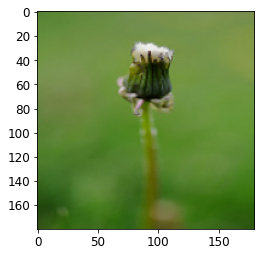

In [12]:
# here is the original image before applying augmentation
plt.imshow(images[image_index].numpy().astype("uint8"))

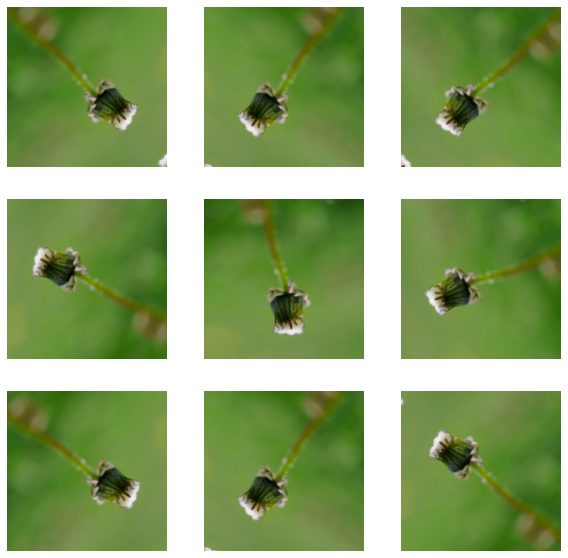

In [13]:
# this demonstrates different rotations and flips
# applied to the image by our preprocessing step
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

# Modern CNN Architectures

## LeNet-5

It was created by Yann LeCun in 1998 and widely used for handwritten digit recognition (MNIST).

<img src="https://drive.google.com/uc?id=14CloqnMJUymq9nFluEiEKx2e5gy57acI">


- MNIST images are 28 × 28 pixels, but they are zero-padded to 32 × 32 pixels and normalized before being fed to the network. 

- For each neuron in the the pooling layer, it computes the mean of its inputs, then multiplies the result by a learnable coefficient (one per map) and adds a learnable bias term (again, one per map), then finally applies the activation function.

- Most neurons in C3 maps are connected to neurons in only three or four S2 maps 

- Output layer: each neuron outputs the square of the Euclidian distance between its input vector and its weight vector. Each output measures how much the image belongs to a particular digit class. 

[Yann LeCun’s website](http://yann.lecun.com/exdb/lenet/index.html) features great demos of LeNet-5 classifying digits.




## AlexNet

- The AlexNet CNN architecture won the 2012 ImageNet ILSVRC challenge:
    - It achieved 17% top-5 error rate while the second best achieved only 26%! 
- It was developed by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton. 
- It is quite similar to LeNet-5, only much larger and deeper, and it was the first to stack convolutional layers directly on top of each other, instead of stacking a pooling layer on top of each convolutional layer. 



<img src="https://drive.google.com/uc?id=1OKLgCmvQl8xF6eokb_tOnS6-CeKJlIeM">

- To reduce overfitting, the authors used two regularization techniques:
    - dropout (with a 50% dropout rate) during training to the outputs of layers F8 and F9. 
    - They performed data augmentation by randomly shifting the training images by various offsets, flipping them horizontally, and changing the lighting conditions.

- AlexNet also uses local response normalization immediately after the ReLU step of layers C1 and C3. This form of normalization makes the neurons that most strongly activate inhibit neurons at the same location but in neighboring feature maps.
    - This normalization encourages different feature maps to specialize, pushing them apart and forcing them to explore a wider range of features, ultimately improving generalization.

$$
b_{i}=a_{i}\left(k+\alpha \sum_{j=j_{\text {linw }}}^{j_{\text {high}}} a_{j}^{2}\right)^{-\beta} \text { with }\left\{\begin{array}{l}{j_{\text {high }}=\min \left(i+\frac{r}{2}, f_{n}-1\right)} \\ {j_{\text {low }}=\max \left(0, i-\frac{r}{2}\right)}\end{array}\right.
$$


- $b_i$ is the normalized output of the neuron located in feature map i, at some row u and column v.

- $a_i$ is the activation of that neuron after the ReLU step, but before normalization.

- $k, \alpha, \beta$ and $r$ are hyperparameters. $k$ is the bias, and $r$ is  the depth radius.

- $f_n$ is the number of feature maps.

- For example, if r = 2 and a neuron has a strong activation, it will inhibit the activation of the neurons located in the feature maps immediately above and below its own.

- In AlexNet, the hyperparameters are set as follows: $r = 2$, $\alpha = 0.00002$, $\beta = 0.75$, and $k = 1$. 

## GoogLeNet

- The GoogLeNet architecture was developed by Christian Szegedy et al. from Google Research.
- Increase in performace mainly comes from much deeper CNNs. 
- GoogLeNet uses sub-networks called inception modules (think of it as an output of feature maps that capture complex patterns at various scales), which allow GoogLeNet to use parameters much more efficiently than previous architectures:
    - GoogLeNet actually has 10 times fewer parameters than AlexNet.

The below diagram illustrates the layers that make up an 'inception' module. “3 × 3 + 2(S)” means that the layer uses a 3 × 3 kernel, stride 2, and SAME padding.
<img src="https://drive.google.com/uc?id=1AiQRlo_RwHPbrpetsiYxTv1OlDl5VuRZ">


- The input signal to the inception module is copied and fed to four different layers. 
- All convolutional layers use the ReLU activation function.
- The second set of convolutional layers uses different kernel sizes (1 × 1, 3 × 3, and 5 × 5), allowing them to capture patterns at different scales. 
- Every single layer uses a stride of 1 and SAME padding , so their outputs all have the same height and width as their inputs. This makes it possible to concatenate all the outputs along the depth dimension in the final depth concat layer 

- The 1 × 1 kernels, serve two purposes:

    - Dimentionality reduction: They are configured to output many fewer feature maps than their inputs; so 1x1 conv filters can be used to change the dimensionality in the filter space.
    - Second, each pair of convolutional layers (`[1 × 1, 3 × 3]` and `[1 × 1, 5 × 5]`) acts like a single, powerful convolutional layer, capable of capturing more complex patterns. 




- The GoogLeNet CNN includes nine inception modules that actually contain three layers each. 
- The six numbers in the inception modules represent the number of feature maps output by each convolutional layer in the module. All the convolutional layers use the ReLU activation function.

<img src="https://drive.google.com/uc?id=1lvGmByHZBuKeVKHt4P3mocfdtiP1wryF">


- The first two layers divide the image’s height and width by 4.
- Then the local response normalization layer ensures that the previous layers learn a wide variety of features.
- Two convolutional layers follow, where the first acts like a bottleneck layer. Bottleneck layers like this are added to reduce the number of feature maps (aka channels) in the network, which otherwise tend to increase in each layer. This is achieved by using 1x1 convolutions with fewer output channels than input channels.
- Next a max pooling layer reduces the image height and width by 2, 
- Then comes the tall stack of nine inception modules, interleaved with a couple max pooling layers to reduce dimensionality.
- Next, the average pooling layer uses a kernel the size of the feature maps with VALID padding, outputting 1 × 1 feature maps. This makes it unnecessary to have several fully connected layers at the top of the CNN, considerably reducing the number of parameters in the network and limiting the risk of overfitting.
- The last layers are: dropout for regularization, then a fully connected layer with a softmax activation function to output estimated class probabilities.




We have immediate access to the `InceptionV3` model architecture from `tf.keras.application`. In fact, this model comes pre-loaded with trained weights, so you can instantiate it and start using it for image classification!

In [ ]:
tf.keras.backend.clear_session()
model = tf.keras.applications.InceptionV3(weights="imagenet")
model.summary()

96124928/96112376 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)           

## ResNet

- Developed by Kaiming He et al.: Extremely deep CNN composed of 152 layers. 
- Some of the connections are skipped (also called shortcut connections): the signal feeding into a layer is also added to the output of a layer located a bit higher up the stack. 

- What the residual part? 
    - When training a neural network, the target function is $h(x)$.
    - If we add the input $x$ to the output, then the network will be forced to model $f(x) = h(x) – x$. 
    This is called residual learning.

<img src="https://drive.google.com/uc?id=1vM5gPVeNU7f_7uT9H4XdY4sYmagLu_fn">



- When a neural network is initialized, its weights are close to zero. If we add a skip connection, the resulting network just outputs a copy of its inputs;
- If the target function is  close to the identity function, this will speed up training.

- With the skip connections, the network can start making progress even if some layers have not started learning yet 

Deep network vs ResNet
<img src="https://drive.google.com/uc?id=1p2-Zu2aKm4g47WH3vdSq4Vm-lijD4A0_">


- The network starts and ends exactly like GoogLeNet, and in between a very deep stack of  residual units. 
- Each residual unit is composed of two convolutional layers, with Batch Normalization (BN) and ReLU activation.


<img src="https://drive.google.com/uc?id=1LqZyfMgjQxIGtOwBrq7M-sicVDpqQtg1">



- The number of feature maps is doubled every few residual units, at the same time as their height and width are halved. 

<img src="https://drive.google.com/uc?id=12eVy1QStz9_D2Cc-iyEJY_gRd6NGpUZ5">


- ResNet-34 is the ResNet with 34 layers,
    - It contains: three residual units that output 64 feature maps, 4 RUs with 128 maps, 6 RUs with 256 maps, and 3 RUs with 512 maps.

- ResNet-152, use diferent residual units, which have three convolutional layers: 
    - first a 1 × 1 convolutional layer with just 64 feature maps ,
    - then a 3 × 3 layer with 64 feature maps, 
    - and finally another 1 × 1 convolutional layer with 256 feature maps
    - ResNet-152 contains three such RUs that output 256 maps, then 8 RUs with 512 maps, a  36 RUs with 1024 maps, and finally 3 RUs with 2,048 maps.

- Other architectures to consider: 
    - VGGNet13 (runner-up of the ILSVRC 2014 challenge) 
    - Inception-v414 (which merges the ideas of GoogLeNet and ResNet and achieves close to 3% top-5 error rate on ImageNet classification)

The following shows how to implement a residual unit as a custom Layer class in Keras. We start by defining this custom layer:

In [ ]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(
                filters, 
                3, 
                strides=strides,
                padding="same", 
                use_bias=False
            ),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(
                filters, 
                3, 
                strides=1,
                padding="same", 
                use_bias=False
            ),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides,
                                    padding="same", use_bias=False),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [ ]:
# now let's assemble a model using this Residual Unit layer

model = keras.models.Sequential()
model.add(
    keras.layers.Conv2D(
        64, 
        7, 
        strides=2, 
        input_shape=[224, 224, 3],
        padding="same", 
        use_bias=False
    )
)
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))

prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
    
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization_94 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 activation_94 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 residual_unit (ResidualUnit  (None, 56, 56, 64)       74240     
 )                                                               
                                                        

You can also access a pretrained resnet model by using following command

In [ ]:
res_model = keras.applications.resnet50.ResNet50(weights="imagenet")
res_model.summary()

102981632/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

<a id="s2"></a>
# Transfer Learning

The training dataset examples we have considered thusfar (e.g. MNIST) have been relatively simple. But what if you want to train a network to robustly classify thousands of different objects? Training these complex nural networks requires a large number of images (e.g. ImageNet contains 1.2 million images with 1000 categories). However, in practice (e.g. classifying images not coming from ImageNet), almost nobody has access to that many images to train complex classifiers from scratch. Instead, it is common to pretrain a CNN on a very large dataset (e.g. ImageNet), and then use the CNN either as an initialization or a fixed feature extractor for the task of interest (e.g. classification). This method is called __Transfer Learning__. 

There are hree major Transfer Learning scenarios as follows:

- __CNN as a fixed feature extractor__: In this strategy, we take a CNN pretrained on ImageNet, remove the last fully-connected layer (this layer’s outputs are the 1000 class scores for a different task like ImageNet), then treat the rest of the CNN as a fixed feature extractor for the new dataset. In an AlexNet, this would compute a 4096-D vector for every image that contains the activations of the hidden layer immediately before the classifier. We call these features __CNN codes__. It is important for performance that these codes are ReLUd (i.e. thresholded at zero) if they were also thresholded during the training of the CNN on ImageNet (as is usually the case). Once we extract the 4096-D codes for all images, we can train a linear classifier (e.g. Linear SVM or Softmax classifier) for the new dataset.

<img src="https://qph.fs.quoracdn.net/main-qimg-9b3d3424df138ad5d7a87506dfddbc94">


<center>Source: https://www.quora.com/How-can-I-use-CNN-for-feature-extraction-of-images</center>

- __Fine-tuning the CNN__: The second strategy is to not only replace and retrain the classifier on top of the CNN on the new dataset, but to also fine-tune the weights of the pretrained network by continuing the backpropagation. It is possible to fine-tune all the layers of the CNN, or it’s possible to keep some of the earlier layers fixed (due to overfitting concerns) and only fine-tune some higher-level portion of the network. This is motivated by the observation that the earlier features of a CNN contain more generic features (e.g. edge detectors or color blob detectors) that should be useful to many tasks, but later layers of the CNN becomes progressively more specific to the details of the classes contained in the original dataset. In case of ImageNet for example, which contains many dog breeds, a significant portion of the representational power of the CNN may be devoted to features that are specific to differentiating between dog breeds.

<img src="https://miro.medium.com/max/2800/1*f2_PnaPgA9iC5bpQaTroRw.png">
<br><br><center>Source: https://medium.com/@subodh.malgonde/transfer-learning-using-tensorflow-52a4f6bcde3e</center>

- __Pretrained models__: Since modern CNNs take 2-3 weeks to train across multiple GPUs on ImageNet, it is common to see people release their final CNN checkpoints for the benefit of others who can use the networks for fine-tuning. For example, many deep learning libraries have Model Zoos where people share their network weights. You can find a collection of TensorFlow models in the <a href="https://github.com/tensorflow/models" target="_blank">TensorFlow Zoo</a>.

<a id=s2.2></a>
### When and How to Fine-tune

How to decide what type of transfer learning we should perform on a new dataset? 

This is a function of several factors, but the two most important ones are the size of the new dataset (small or big), and its similarity to the original dataset (e.g. ImageNet-like in terms of the content of images and the classes, or very different, such as microscope images). Keeping in mind that CNN features are more generic in early layers and more dataset-specific in later layers, here are some common rules of thumb for navigating the 4 major scenarios:

- __New dataset is small and similar to original dataset__: Since the data is small, it is not a good idea to fine-tune the CNN due to overfitting concerns. Since the data is similar to the original data, we expect higher-level features in the CNN to be relevant to this dataset as well. Hence, the best idea might be to train a linear classifier on the CNN codes.


- __New dataset is large and similar to the original dataset__: Since we have more data, we can have more confidence that we won’t overfit if we were to try to fine-tune through the full network.


- __New dataset is small but very different from the original dataset__: Since the data is small, it is likely best to only train a linear classifier. Since the dataset is very different, it might not be best to train the classifier form the top of the network, which contains more dataset-specific features. Instead, it might work better to train the SVM classifier from activations somewhere earlier in the network.


- __New dataset is large and very different from the original dataset__: Since the dataset is very large, we may expect that we can afford to train a CNN from scratch. However, in practice it is very often still beneficial to initialize with weights from a pretrained model. In this case, we would have enough data and confidence to fine-tune through the entire network.

For more details, you can refer to this paper https://arxiv.org/abs/1411.1792. 

<a id=s2.3></a>
### Practical Notes

- __Constraints from pretrained models__: Note that if you wish to use a pretrained network, you may be slightly constrained in terms of the architecture you can use for your new dataset. For example, you can’t arbitrarily take out Conv layers from the pretrained network. However, some changes are straight-forward: Due to parameter sharing, you can easily run a pretrained network on images of different spatial size. This is clearly evident in the case of Conv/Pool layers because their forward function is independent of the input volume spatial size (as long as the strides “fit”). In case of FC layers, this still holds true because FC layers can be converted to a Convolutional Layer: For example, in an AlexNet, the final pooling volume before the first FC layer is of size [6x6x512]. Therefore, the FC layer looking at this volume is equivalent to having a Convolutional Layer that has receptive field size 6x6, and is applied with padding of 0.


- __Learning rates__: It’s common to use a smaller learning rate for CNN weights that are being fine-tuned, in comparison to the (randomly-initialized) weights for the new linear classifier that computes the class scores of your new dataset. This is because we expect that the CNN weights are relatively good, so we don’t wish to distort them too quickly and too much (especially while the new Linear Classifier above them is being trained from random initialization).

<a id=s2.4></a>
### Transfer Learning & Fine-tuning in Keras/Tensorflow

 #### Using Pre-trained Models


In [ ]:
import warnings
warnings.simplefilter("ignore")

# VGG16 pre-trained model without fully connected layers and with different input dimensions
image_w, image_h = 180, 180
model = tf.keras.applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
# Trainable layers
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)


0 input_3 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
# Freezing the layers we don't want to train (here I freeze  until the end of block 2 = 7 layers)
for layer in model.layers[:17]:
    layer.trainable = False

In [ ]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 True
18 block5_pool True


In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
# Adding custom layers to the output to create a new model 
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import optimizers

new_model = Sequential([
    model,
    Flatten(name='flatten'),
    Dense(260, activation='relu', name='new_fc1', kernel_initializer="HeNormal"),
    Dense(100, activation='relu', name='new_fc2', kernel_initializer="HeNormal"),
    Dense(5, name='new_predictions')
])


In [ ]:
new_model.layers

In [ ]:
# Compiling the model
new_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer = tf.keras.optimizers.Adam(lr=0.01), 
    metrics=["accuracy"]
)

In [ ]:
# our training dataset will be the collection of flower images that
# we loaded into the DataSet API earlier:
print(type(train_ds))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [ ]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 new_fc1 (Dense)             (None, 260)               3328260   
                                                                 
 new_fc2 (Dense)             (None, 100)               26100     
                                                                 
 new_predictions (Dense)     (None, 5)                 505       
                                                                 
Total params: 18,069,553
Trainable params: 5,714,673
Non-trainable params: 12,354,880
_________________________________________________________________


In [ ]:
# let's train it and see what happens...
new_model.fit(train_ds, validation_data=validation_ds, epochs=10)

Epoch 1/10
92/92 [==============================] - 21s 188ms/step - loss: 129.9426 - accuracy: 0.2933 - val_loss: 1.5842 - val_accuracy: 0.2902
Epoch 2/10
92/92 [==============================] - 14s 149ms/step - loss: 6.2161 - accuracy: 0.2725 - val_loss: 1.5810 - val_accuracy: 0.2548
Epoch 3/10
92/92 [==============================] - 14s 150ms/step - loss: 2.4374 - accuracy: 0.2381 - val_loss: 1.6039 - val_accuracy: 0.2398
Epoch 4/10
92/92 [==============================] - 14s 150ms/step - loss: 1.5961 - accuracy: 0.2473 - val_loss: 1.6042 - val_accuracy: 0.2398
Epoch 5/10
92/92 [==============================] - 14s 151ms/step - loss: 1.5951 - accuracy: 0.2476 - val_loss: 1.6029 - val_accuracy: 0.2398
Epoch 6/10
92/92 [==============================] - 14s 151ms/step - loss: 1.5950 - accuracy: 0.2476 - val_loss: 1.6027 - val_accuracy: 0.2398
Epoch 7/10
92/92 [==============================] - 14s 151ms/step - loss: 1.5951 - accuracy: 0.2476 - val_loss: 1.6030 - val_accuracy: 0.23

Uh oh, our validation accuracy wasn't that great, what happened?
Our dataset wasn't large enough to prevent overfitting when we unfreezed
some of the pre-trained layers. Let's try a slightly different approach.

In [ ]:
print(f"Number of training samples: {len(list(train_ds))}")

Number of training samples: 92


#### Exercise

Try freezing all the layers in above example and retrain the model. Explain your observations

In [ ]:
# Your code here .....

In [ ]:
# Your code here .....

In [ ]:
# Your code here .....

In [ ]:
# Your code here .....

In [ ]:
# Your code here .....

##### Solution 

In [ ]:
model = tf.keras.applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))

In [ ]:
# we'll freeze all of our pre-trained layers and only
# train the dense layers we added for classification
for layer in model.layers:
    layer.trainable = False

In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
new_model = Sequential([
    model,
    Flatten(name='flatten'),
    Dense(260, activation='relu', name='new_fc1', kernel_initializer="HeNormal"),
    Dense(100, activation='relu', name='new_fc2', kernel_initializer="HeNormal"),
    Dense(5, name='new_predictions')
])

In [ ]:
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 new_fc1 (Dense)             (None, 260)               3328260   
                                                                 
 new_fc2 (Dense)             (None, 100)               26100     
                                                                 
 new_predictions (Dense)     (None, 5)                 505       
                                                                 
Total params: 18,069,553
Trainable params: 3,354,865
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
new_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer = tf.keras.optimizers.Adam(lr=0.01), 
    metrics=["accuracy"]
)

In [ ]:
new_model.fit(train_ds, validation_data=validation_ds, epochs=10)

Epoch 1/10
92/92 [==============================] - 15s 151ms/step - loss: 10.6945 - accuracy: 0.5279 - val_loss: 1.0514 - val_accuracy: 0.6485
Epoch 2/10
92/92 [==============================] - 14s 151ms/step - loss: 1.0797 - accuracy: 0.6655 - val_loss: 1.1888 - val_accuracy: 0.6390
Epoch 3/10
92/92 [==============================] - 14s 151ms/step - loss: 0.9171 - accuracy: 0.6935 - val_loss: 1.0708 - val_accuracy: 0.7302
Epoch 4/10
92/92 [==============================] - 14s 154ms/step - loss: 0.8369 - accuracy: 0.7020 - val_loss: 1.0147 - val_accuracy: 0.6335
Epoch 5/10
92/92 [==============================] - 14s 152ms/step - loss: 0.7413 - accuracy: 0.6880 - val_loss: 0.9516 - val_accuracy: 0.6322
Epoch 6/10
92/92 [==============================] - 14s 152ms/step - loss: 0.6585 - accuracy: 0.7302 - val_loss: 1.3745 - val_accuracy: 0.6866
Epoch 7/10
92/92 [==============================] - 14s 151ms/step - loss: 0.6879 - accuracy: 0.7044 - val_loss: 1.1615 - val_accuracy: 0.576

You notice in the second version, you will get better performance since we have less weights. In the first version since we have lots of weights and not much data **overfitting** is happening.

# Visualizing Intermediate Activations

What are the feature maps that our network is learning?

We could display the individual filters learned by the network, but these are often quite difficult to interpret. 

We could also try feeding our network an input image, and seeing what intermediate activations light up in each feature map. This works well for understanding the first few layers, but gets tricky the deeper we go, because the activations in deeper layers depend on filter activations in the layer below that, and the layer below that, etc. 

An alternative approach is to choose a specific feature map that we want to better understand, and then try to synthetically generate an input image that maximizes the activations in that image. The resultant synthetic images tell us how what that particular feature map 'detects' relates back to the original image.  

There is an excellent interactive article explaining this approach to feature visualization, found here: https://distill.pub/2017/feature-visualization/


The same article also has an appendix that lets you explore some of the channels of GoogLeNet in terms of the input images that maximize (and conversely, minimize) their activations: https://distill.pub/2017/feature-visualization/appendix/

For more discussion on visualizing intermediate activations in general, these are also great references:

- https://keras.io/examples/vision/visualizing_what_convnets_learn/ 

- https://huggingface.co/spaces/keras-io/what-convnets-learn


# Additional Resources

- Convolutional Neural Networks w/ TF:
    - https://www.tensorflow.org/tutorials/images/deep_cnn

- Build a Convolutional Neural Network using Estimators
    - https://www.tensorflow.org/tutorials/estimators/cnn
    
- Keras conv networks:
    - https://keras.io/layers/convolutional/
    - https://keras.io/applications/
    
- Deep Learning book
    - Ian Goodfellow and Yoshua Bengio and Aaron Courville
    - https://www.deeplearningbook.org/contents/convnets.html

- Visulazing techniques 
    - [LIME](https://github.com/marcotcr/lime)
    - [SHAP](https://github.com/slundberg/shap)